# Introduction

This notebook will serve to present the results obtained with the Super Resolution model.

We will show validation results of the best model found during model selection and test results.

The training was computed on an Nvidia laptop GPU with the following specifications:

In [18]:
! nvidia-smi

Tue Aug  6 12:28:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 555.58.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   50C    P3             14W /   30W |     538MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [19]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from dataset.data_preparation import download, split_dataset
from dataset.super_resolution_dataset import SuperResolutionDataset
import matplotlib.pyplot as plt
from numpy import genfromtxt
import seaborn as sns
import numpy as np
from SRM.network import SuperResolution
from torchmetrics.functional.image import peak_signal_noise_ratio
sns.set_style("darkgrid")
sns.set_context("talk")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Download the dataset

Set a seed for reproducibility. This seed is the same used in the main method to achieve the same results

In [20]:
torch.manual_seed(777)

download("./data", "airplanes")
root_dir = 'data/airplanes'
dataset = SuperResolutionDataset(root_dir=root_dir)
dataset_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

Dataset airplanes already exists, skipping download.


## Exploring the dataset

The dataset is composed by couples of low and high resolution images.
The images are 128x64 and 256x128 respectively.
For simplicity, we have cropped all the images to have the same dimension.

> The dataset is made just of airplanes images

Below there is a plot with a low resolution image with the corresponding high resolution image.

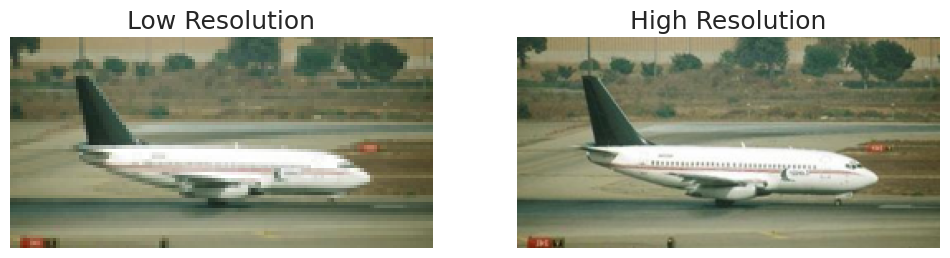

In [21]:
low_res, high_res = next(iter(dataset_dataloader))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(low_res[0].permute(1, 2, 0))
ax[0].set_title("Low Resolution")
ax[0].axis('off')

ax[1].imshow(high_res[0].permute(1, 2, 0))
ax[1].set_title("High Resolution")
ax[1].axis('off')

plt.show()

# Data Splitting

We will use the same split size used during training.

In [22]:
sizes = {
    "train":0.5,
    "validation":0.3,
    "test":0.2
}
_ , validation, test = split_dataset(dataset,sizes)

validation_dataloader = DataLoader(test, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test, batch_size=16, shuffle=True)

# Learning

The model has been trained for 50 epochs for validation purpose, after that it was trained for another 150 epochs with training and validation dataset merged together.

## Learning Curve of L1 loss

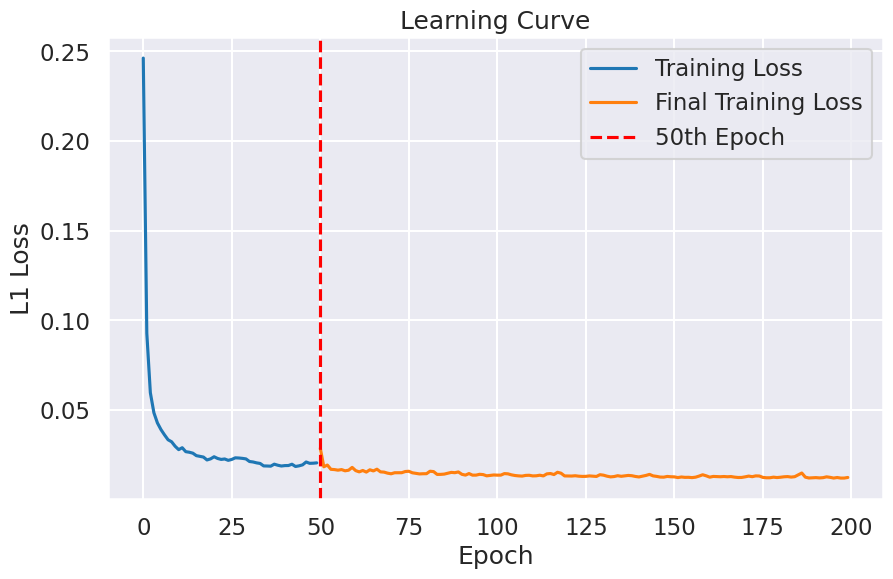

In [23]:
training_loss = "training_logs/202408051714_L1.csv"
final_training_loss = "training_logs/202408051740_L1.csv"
training_loss = genfromtxt(training_loss, delimiter=',')
final_training_loss = genfromtxt(final_training_loss, delimiter=',')

plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(len(training_loss)), y=training_loss, label='Training Loss')
sns.lineplot(x=np.arange(len(training_loss), len(training_loss) + len(final_training_loss)), 
             y=final_training_loss, label='Final Training Loss')

plt.axvline(x=50, color='red', linestyle='--', label='50th Epoch')
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

## PSNR in decibel

The peak signal-to-noise ratio is a measurement for image quality with the following convention:

-  PSNR < 20 Low quality
-  20 < PSNR < 30 Medium quality
- PSNR > High quality

Quality is respect to the original image, it does not mean that the image is in high resolution.

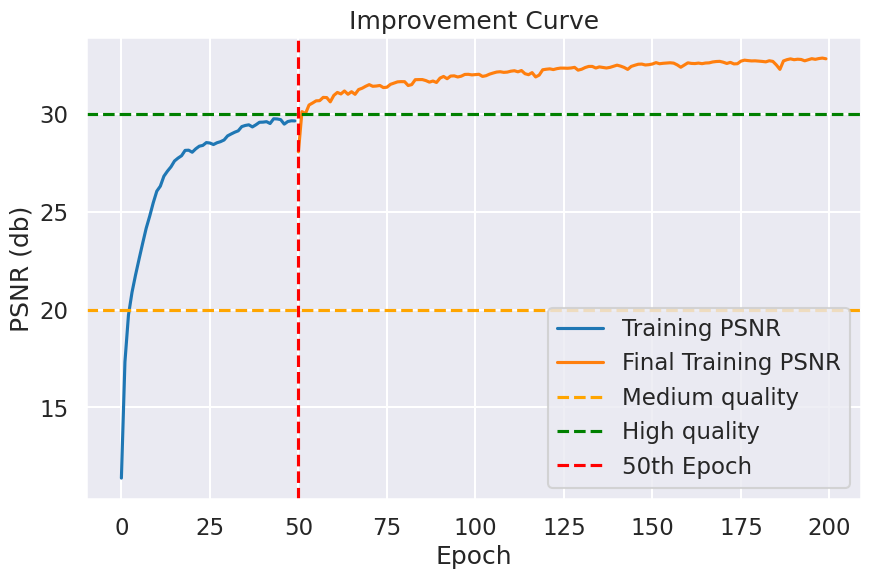

In [24]:
training_psnr = "training_logs/202408051714_psnr.csv"
final_training_psnr = "training_logs/202408051740_psnr.csv"
training_psnr = genfromtxt(training_psnr, delimiter=',')
final_training_psnr = genfromtxt(final_training_psnr, delimiter=',')

plt.figure(figsize=(10, 6))
sns.lineplot(x=np.arange(len(training_psnr)), y=training_psnr, label='Training PSNR')
sns.lineplot(x=np.arange(len(training_psnr), len(training_psnr) + len(final_training_psnr)), 
             y=final_training_psnr, label='Final Training PSNR')

plt.axhline(y=20, color='orange', linestyle='--', label='Medium quality')
plt.axhline(y=30, color='green', linestyle='--', label='High quality')

plt.axvline(x=50, color='red', linestyle='--', label='50th Epoch')
plt.xlabel('Epoch')
plt.ylabel('PSNR (db)')
plt.title('Improvement Curve')
plt.legend()
plt.show()

# Validation and visual comparison

We can load the trained model with 50 epochs (used for validation) to get the Loss and PSNR values.


Validation L1: 0.017452210560441016, PSNR 30.271738052368164 db


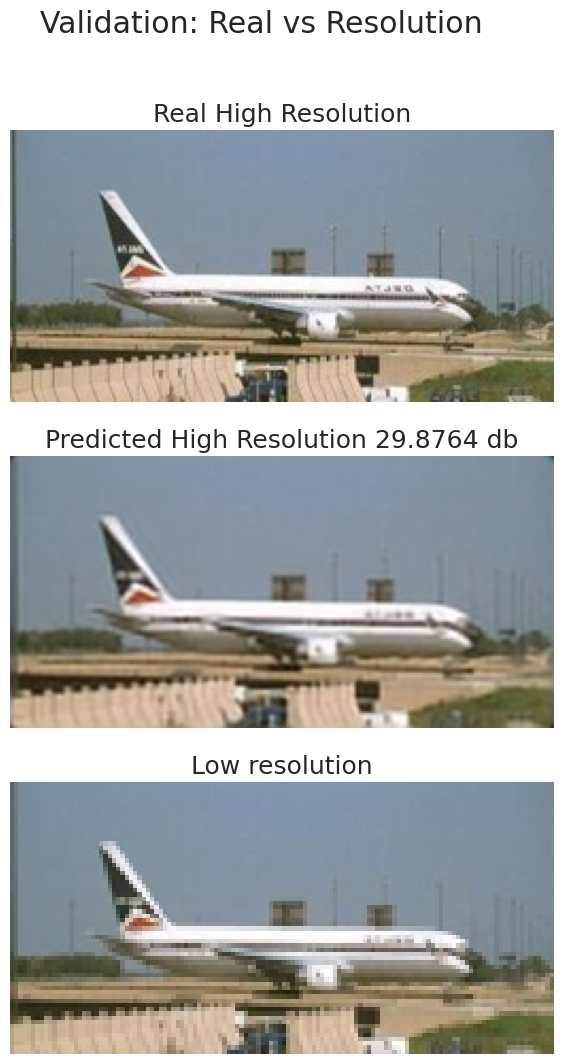

In [36]:
from utils.training_utilitis import validate
model_filename = "checkpoint/SR_c64_rb8_e50_202408051714.pth"
validation_SRN = SuperResolution(64,8)
checkpoint_path = model_filename
validation_SRN.load_state_dict(torch.load(checkpoint_path))

loss, psnr = validate(validation_SRN,validation_dataloader,
                      {"loss_fn":nn.L1Loss(),"device":device})
print(f"Validation L1: {loss}, PSNR {psnr} db")

low_res_validation, high_res_validation = next(iter(validation_dataloader))

low_res_validation = low_res_validation.to(device)
high_res_validation = high_res_validation.to(device)

with torch.no_grad():
    predicted_high_res = validation_SRN(low_res_validation)
    
validation_psnr = peak_signal_noise_ratio(predicted_high_res, high_res_validation)

predicted_image = torch.clamp(predicted_high_res[0], 0, 1).permute(1, 2, 0).cpu().numpy()
_, ax = plt.subplots(3, figsize=(16, 12)) 
plt.suptitle("Validation: Real vs Resolution")

ax[0].imshow(high_res_validation[0].permute(1, 2, 0).cpu())
ax[0].set_title("Real High Resolution")
ax[0].axis('off') 

ax[1].imshow(predicted_image)
ax[1].set_title(f"Predicted High Resolution {validation_psnr:.4f} db")
ax[1].axis('off')

ax[2].imshow(low_res_validation[0].permute(1, 2, 0).cpu())
ax[2].set_title(f"Low resolution")
ax[2].axis('off')

os.makedirs("output", exist_ok=True) 
plt.savefig("output/validation_prediction_comparison.jpg")
plt.show()

# Test and visual comparison

We can load the final model to test it and get Loss and PSNR values.

Test L1: 0.012139984220266343, PSNR 32.92205047607422 db


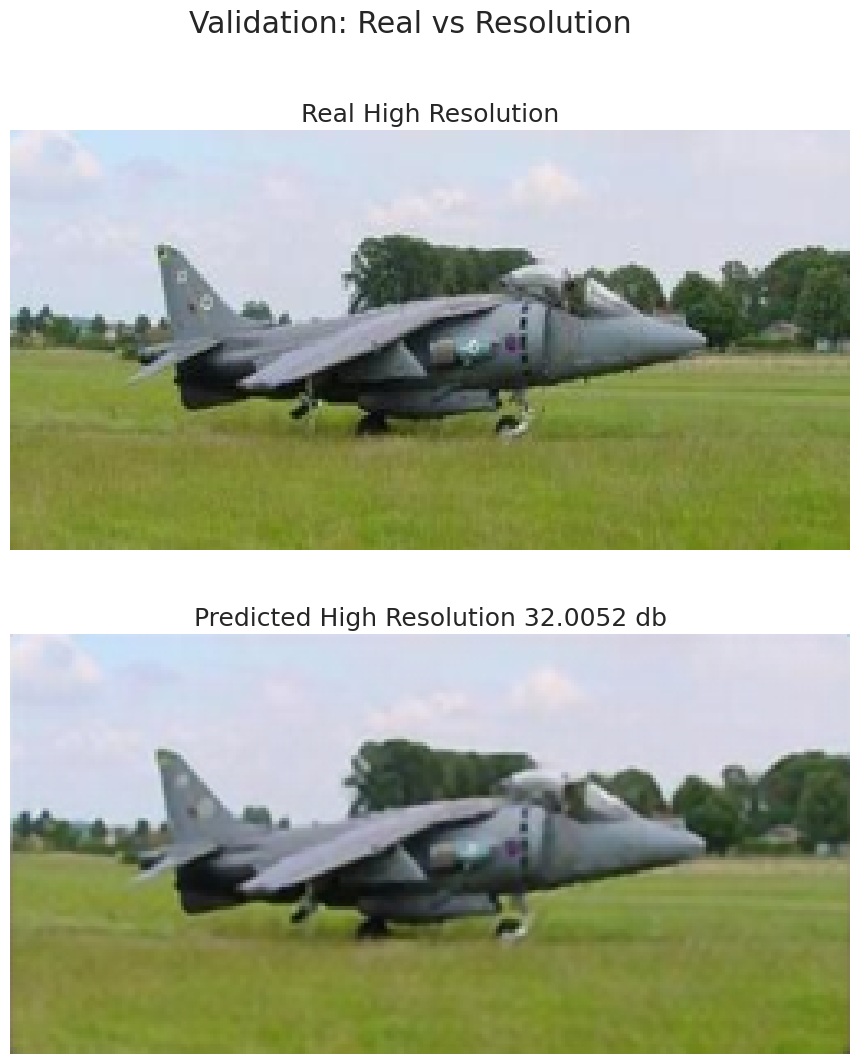

In [27]:
model_filename = "checkpoint/SR_c64_rb8_e150_202408051740.pth"
test_SRN = SuperResolution(64,8)
checkpoint_path = model_filename
test_SRN.load_state_dict(torch.load(checkpoint_path))

loss, psnr = test_SRN.test(nn.L1Loss(), test_dataloader ,device)
print(f"Test L1: {loss}, PSNR {psnr} db")

low_res_test, high_res_test = next(iter(test_dataloader))

low_res_test = low_res_test.to(device)
high_res_test = high_res_test.to(device)

with torch.no_grad():
    predicted_high_res = test_SRN(low_res_test)
    
test_psnr = peak_signal_noise_ratio(predicted_high_res, high_res_test)    
predicted_image = torch.clamp(predicted_high_res[0], 0, 1).permute(1, 2, 0).cpu().numpy()
_, ax = plt.subplots(2, figsize=(16, 12)) 
plt.suptitle("Validation: Real vs Resolution")

ax[0].imshow(high_res_test[0].permute(1, 2, 0).cpu())
ax[0].set_title("Real High Resolution")
ax[0].axis('off') 

ax[1].imshow(predicted_image)
ax[1].set_title(f"Predicted High Resolution {test_psnr:.4f} db")
ax[1].axis('off')

os.makedirs("output", exist_ok=True) 
plt.savefig("output/test_prediction_comparison.jpg")
plt.show()